# Laboratory of Computational Physics mod.B

## Fifth assignment

### Group name: LoCPdown
### Components:
* Campesan Giulia (2027592)
* Faorlin Tommaso (2021857)
* Marcomini Alessandro (2024286)

### Objective:

The aim of this notebook is to implement some techniques concerning the Restricted Boltzmann Machines (RBM) to analyse some corrupted data sequences. We will compare an econding of them via bit or spin levels (0,1 or -1,1 notation).

In [2]:
#import packages
import numpy as np
import pandas as pd

from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from IPython.display import Latex

In [6]:
#this cell contains some user defined function useful later on

def create_coord(np, x0):
    '''
    
    normalize in a box all the visible and hidden units
    
    '''
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5 
        
    return (x,y)

def mycolor(val):
    '''
    
    define a custom color for lines and dots
    
    '''
    if val>0:
        return 'red'
    elif val<0:
        return 'blue'
    return 'black'

def plotgraph(M, epoch=0):
    '''
    
    plot the boltzmann layers and weights
    
    '''
    A = 2. / w.max()
    (x1, y1) = create_coord(L,0)
    (x2, y2) = create_coord(M,1)
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i,j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i,j]))
    A = 300./(a.max()+b.max())
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*np.abs(a[i]), zorder=2, c=mycolor(a[i]))
    plt.title(f'>0 red, <0 blue,epoch={epoch}')
    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*np.abs(b[j]), zorder=2, c=mycolor(b[j]))
    plt.title(f'>0 red, <0 blue,epoch={epoch}')
    plt.show()
    
def activate(v_in, wei, bias, DE, info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + np.exp(-DE*act))
    n = len(act)
    v_out = np.full(n, vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('out=', v_out)
        
    return(v_out)

def mountain_plot(betas, z):
    '''
    
    plots the moutain-shaped graph with the accuracy for a mesh of betas
    

    '''
    x, y = np.meshgrid(betas, betas)

    fig = plt.figure()
    ax = Axes3D(fig)

    #plot the surface.
    surf = ax.plot_surface(x,y, z, vmin=30.,vmax=90., cmap='gist_earth')

    #add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel('$\\beta$, positive phase')
    ax.set_ylabel('$\\beta$, negative phase')
    ax.set_zlabel('accuracy')
    ax.view_init(30,200)

    plt.show()
    
def mean_square_increment(dw):
    '''
    
    calculate the means squared increment given the weights
    
    '''
    total = 0
    for i in range(L):
        for j in range(M):
            total += dw[i,j]**2
    total /= L*M
    
    return total

def evaluate_beta(beta_p, beta_n, v0, v_uncurrupted, a, b, w):
    '''
    
    given the sequences before and after RBM, this function trains the RBM and
    compute the comparison with the uncurrupted data for different beta
    
    
    '''
    v2 = np.full((N, L), vmin)
    for n in range(N):
        h = activate(v0[n], w,b,GAP*beta_p)
        v2[n] = activate(h, w.T,a,GAP*beta_n)
    
    vdiff = np.sum(np.abs(v_uncurrupted-v2), axis=1)
    tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
    perc = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100
    
    return tot, perc 


def training_RBM(M,w,a,b,info=True):

    #minibatches
    mini, m = 500, 0 
    #epochs
    nepoch = 50
    #l_rate
    l_rate = 1.

    for epoch in range(1, 1+nepoch):
        for n in range(N):
            if m==0:
                #initialize
                v_data, v_model = np.zeros(L), np.zeros(L) 
                h_data, h_model = np.zeros(M), np.zeros(M) 
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

            #positive CD phase
            h = activate(v[n],w,b,GAP)
            #negative CD phase
            vf = activate(h, w.T,a,GAP)
            #positive CD nr 2
            hf = activate(vf,w,b, GAP)

            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1
            if m==mini:
                C = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C * (h_data - h_model)

                w += dw
                a += da
                b += db
                m = 0

        #randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (0.05 * l_rate + 1)
        
        if info:
            if (epoch % 50 == 0):
                plotgraph(M,epoch)
                print(' l_rate=', l_rate)
                
    return w,a,b

## Machine definition and training

The dataset we work on is made of several sequences generated from a couple of random bits (i.e., they contain the same amount of information of a two bit number but embody it with a certain amount of redundancy). The dataset has been corrupted with a bit-flip function tuned to act according to the corruption probability (in this first case, $q=10\%$).

We start by encoding the data in the 'spins' format, namely with +1 and -1 in the sequences.
We define the structure of the RBM: for the first training, we implement a 3-hidden-units RBM with unitary $\beta$.

In [3]:
#we load the sequences generated with the file coded at lesson

#corruption probability
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])
    
#here we select the encoding
SPINS = True

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]


In [4]:
# number of hidden units
M=3

#stdev of initialized weights
sigma = np.sqrt(4. / float(N+M))

#initialized weights
w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

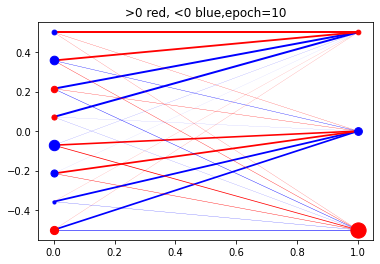

 l_rate= 0.6666666666666663


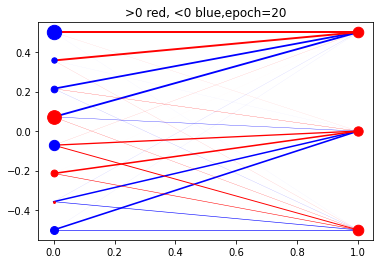

 l_rate= 0.5


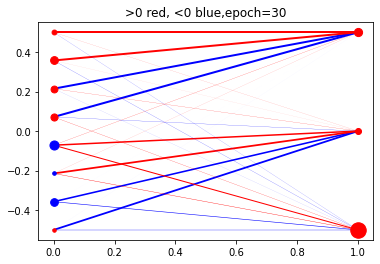

 l_rate= 0.4000000000000001


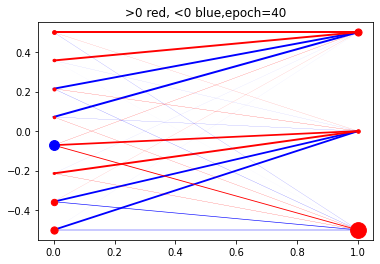

 l_rate= 0.3333333333333335


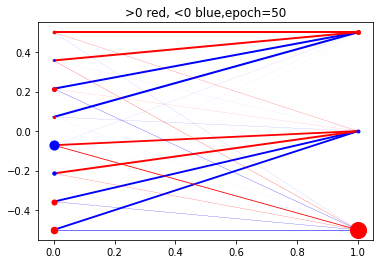

 l_rate= 0.28571428571428586


In [5]:
#minibatches
mini, m = 500, 0 
#epochs
nepoch = 50
#l_rate
l_rate = 1.
#dw
weights_spin = np.zeros(nepoch)

for epoch in range(1, 1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L) 
            h_data, h_model = np.zeros(M), np.zeros(M) 
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h, w.T,a,GAP)
        #positive CD nr 2
        hf = activate(vf,w,b, GAP)

        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)

        m += 1
        if m==mini:
            C = l_rate / mini
            dw = C*(vh_data - vh_model)
            da = C*(v_data - v_model)
            db = C * (h_data - h_model)
            weights_spin[epoch-1] = mean_square_increment(dw)
            w += dw
            a += da
            b += db
            m = 0
            
    #randomize order
    np.random.shuffle(v)
    l_rate = l_rate / (0.05 * l_rate + 1)
    if (epoch % 10 == 0):
        plotgraph(M,epoch)
        print(' l_rate=', l_rate)

The previous graphs report the values of neurons and edges (red colour indicates positive values, blue negative ones). The stronger the colour intensity is, the higher the signed value.

After a sufficient number of epochs with adaptive learning rate, the training of the RBM is concluded with two properly working neurons depending only on four input units each (as we expect because of the two-bit information embodied with a four-bit redundancy), while one extra hidden unit is basically turned off. 

## 1,2) Different $\beta$ performance analysis & corrupted/non-corrupted comparison

The aim of the first section is to see how denoising works while changing the $\beta \equiv 1/T$ parameter in the sigmoid function in the fantasy data generation of our RBM model. We perform a grid search varying $\beta$ for both the positive phase (hidden units generation) and the negative phase (fantasy data generation).

In order to do so, we generate the correspondent uncorrupted dataset by setting the corruption probability to 0 
and define an accuracy function as the percentage of correctly denoised sequences after the action of the RBM on the corrupted dataset, via one-to-one comparison.


In [6]:
#number of different betas and linspace
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

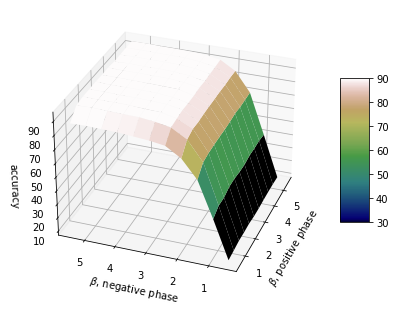

In [7]:
mountain_plot(betas, percs)

In [8]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print("====================================")
print("Accuracy before denoising: ", acc_bf_denois, "%")
print("Accuracy after denoising:  ", acc_at_denois, "%")
print("====================================")

Accuracy before denoising:  43.21 %
Accuracy after denoising:   94.64 %


**Before** the denoising, the accuracy is equal to 43.2\% $\sim0.9^8\times 100\sim43\%$, that is the theoretical probability to obtain two equal strings if the bit-flip probability is $0.1$.

**After** the denoising we reach an accuracy of about 94\%, almost doubling the one before denoising.
We can then conlcude that the correction has been working succesfully.

Looking at the plot above, one can also notice how enlarging $\beta$ for the negative phase improves greatly the accuracy of the Boltzmann machine, while varying the positive phase $\beta$ does not affect the performances overall.








?

## 3a) Introducing a fifth state

We now analyse the behaviour if we add (with equal probability w.r.t. the others) a fifth state of the kind '**11111111**'. Again, we add a small corruption $q=0.1$. We also aim to find the optimal number of hidden units $M$ to maximize the accuracy with this new dataset (among different values). 

In [3]:
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'_seq4.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

[1 1 1 1 1 1 1 0]
[1 1 1 0 1 0 0 1]
[0 0 1 1 1 0 0 1]
[1 0 1 1 1 1 0 0]
[1 0 1 1 1 1 1 1]
[1 1 0 0 1 0 1 1]
[1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1]
[0 0 1 1 1 0 0 0]
[1 1 0 0 1 1 0 0]


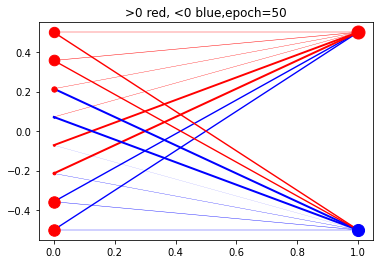

 l_rate= 0.28571428571428586


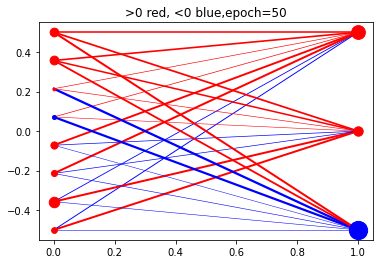

 l_rate= 0.28571428571428586


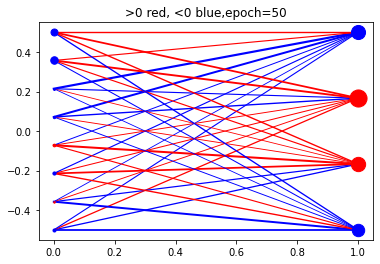

 l_rate= 0.28571428571428586


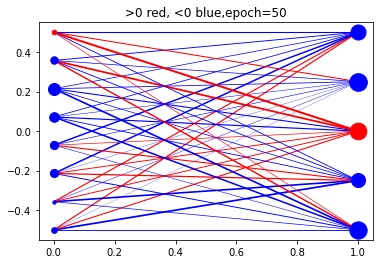

 l_rate= 0.28571428571428586


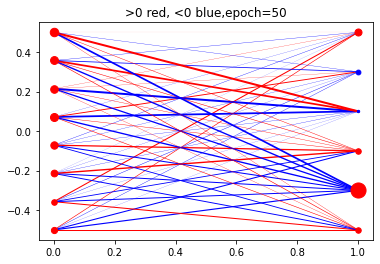

 l_rate= 0.28571428571428586


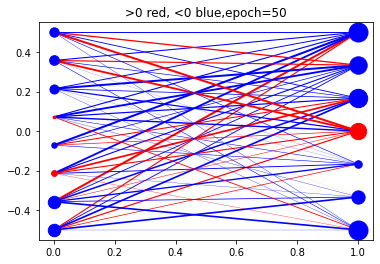

 l_rate= 0.28571428571428586


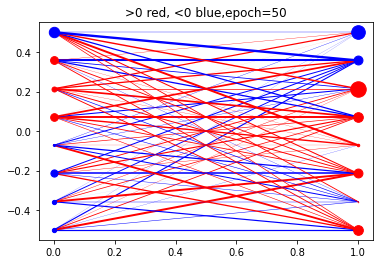

 l_rate= 0.28571428571428586


In [7]:
M_list = [2,3,4,5,6,7,8]
W_list = []
a_list = []
b_list = []

#we construct here our RBM initializing randomly the weights
    
    #number of hidden units
for M in M_list:
    sigma = np.sqrt(4. / float(N+M))
    w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)

    w_t, a_t, b_t = training_RBM(M,w,a,b)
    
    W_list.append(w_t)
    a_list.append(a_t)
    b_list.append(b_t)

In [8]:
#probability (null) of corruption for perfectly-generated data
q1 = 0
n_betas = 7

betas = np.linspace(0.5, 7.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq4.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1
    
tots, percs = np.zeros((len(M_list), n_betas)), np.zeros((len(M_list), n_betas))

for i in range(len(M_list)):
    for j in range(n_betas):
        tot, perc = evaluate_beta(1., betas[j], v0, v_uncurrupted, a_list[i], b_list[i], W_list[i])
        tots[i,j] = tot
        percs[i, j] = perc 

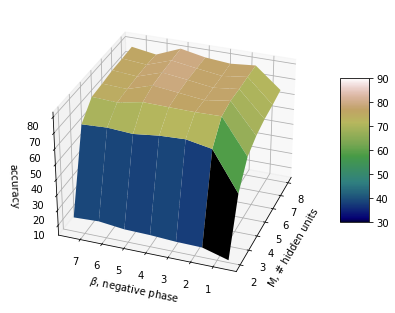

In [9]:
x,y = np.meshgrid(M_list,betas)
fig = plt.figure()
ax = Axes3D(fig)

#plot the surface.
surf = ax.plot_surface(x,y, percs, vmin=30.,vmax=90., cmap='gist_earth')

#add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('M, # hidden units')
ax.set_ylabel('$\\beta$, negative phase')
ax.set_zlabel('accuracy')
ax.view_init(30,200)

plt.show()   

In [ ]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print("====================================")
print("Accuracy before denoising: ", acc_bf_denois, "%")
print("Accuracy after denoising:  ", acc_at_denois, "%")
print("====================================")

With respect to the case with only 4 sequences the optimal Boltzmann machine performs slightly worse. This could be due also to the fact that the structure of the fifth state needs a global vision to be identified, at difference with what happens with the other four sequences.

## 3b) Introducing a sixth state

We now see what happens if we add (with equal probability wrt others) a sixth state of the kind '**10101000**'. We add a small corruption probability $q=10\%$.

In [ ]:
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'_seq45.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

In [ ]:
M_list = [2,3,4,5,6,7,8]
W_list = []
a_list = []
b_list = []

#we construct here our RBM initializing randomly the weights
    
    #number of hidden units
for M in M_list:
    sigma = np.sqrt(4. / float(N+M))

    w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)

    #----------------------------

    #minibatches
    mini, m = 500, 0 
    #epochs
    nepoch = 50
    #l_rate
    l_rate = 1.
    #dw
    weights_spin = np.zeros(nepoch)

    for epoch in range(1, 1+nepoch):
        for n in range(N):
            if m==0:
                #initialize
                v_data, v_model = np.zeros(L), np.zeros(L) 
                h_data, h_model = np.zeros(M), np.zeros(M) 
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

            #positive CD phase
            h = activate(v[n],w,b,GAP)
            #negative CD phase
            vf = activate(h, w.T,a,GAP)
            #positive CD nr 2
            hf = activate(vf,w,b, GAP)

            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1
            if m==mini:
                C = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C * (h_data - h_model)
                weights_spin[epoch-1] = mean_square_increment(dw)

                w += dw
                a += da
                b += db
                m = 0

        #randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (0.05 * l_rate + 1)

        if (epoch == nepoch):
            plotgraph(M,epoch)
            print(' l_rate=', l_rate)

            W_list.append(w)
            a_list.append(a)
            b_list.append(b)

In [ ]:
#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 5
betas = np.linspace(0.5, 5.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq45.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

In [ ]:
#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 7
betas = np.linspace(0.5, 7.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq45.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

    
tots, percs = np.zeros((len(M_list), n_betas)), np.zeros((len(M_list), n_betas))

for i in range(len(M_list)):
    for j in range(n_betas):
        tot, perc = evaluate_beta(1., betas[j], v0, v_uncurrupted, a_list[i], b_list[i], W_list[i])
        tots[i,j] = tot
        percs[i, j] = perc 

In [ ]:
print(percs)
x, y = np.meshgrid(M_list, betas)

fig = plt.figure()
ax = Axes3D(fig)

#plot the surface.
surf = ax.plot_surface(x,y, percs, vmin=30.,vmax=90., cmap='gist_earth')

#add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('M, # hidden units')
ax.set_ylabel('$\\beta$, negative phase')
ax.set_zlabel('accuracy')
ax.view_init(30,200)

plt.show()   

In [ ]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print("====================================")
print("Accuracy before denoising: ", acc_bf_denois, "%")
print("Accuracy after denoising:  ", acc_at_denois, "%")
print("====================================")

## 4) Larger error rate

We now see how the behaviour change when introducing a larger spin-flip probability, i.e. a larger error rate.
In particular, we study the behaviour of the denoising process for a corruption probability $q=20\%$.

#### 4.1,2) Different $\beta$ performance analysis & corrupted/non-corrupted comparison

In [ ]:
#corruption probability
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])
    
#here we select the encoding
SPINS = True

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

w,a,b = training_RBM(M,w,a,b, info=False)

#number of different betas and linspace
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
        
        
        
mountain_plot(betas, percs)

#### Enlarging beta's range

Since, as expected, we notice a decrease in accuracy, due to how the dataset has been generated, we try to decrease the temperature w.r.t. the lower noise case studied before.
This leads to an increase of the accuracy of about 5$\%$, that displays a plateau at $\sim 80 \%$ accuracy

In [ ]:
#number of hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)


w,a,b = training_RBM(M,w,a,b, info=False)

#number of different betas and linspace
n_betas = 16
betas = np.linspace(0.5, 15.5, n_betas)

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
mountain_plot(betas, percs)

#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

In [ ]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print(acc_at_denois)

#### 4.3a) Introducing a fifth state
qua è da sistemare l'M 

In [ ]:
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'_seq4.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 5

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

w,a,b = training_RBM(M,w,a,b, info=False)


#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 16
betas = np.linspace(0.5, 15.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq4.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
        
mountain_plot(betas, percs)

In [ ]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

#### 4.3b) Introducing a sixth state

In [ ]:
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'_seq45.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 4

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

w,a,b = training_RBM(M,w,a,b, info=False)

#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 16
betas = np.linspace(0.5, 15.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq45.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
mountain_plot(betas, percs)


#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

## 5) Binary encoding

We now change the encoding to the 'bits' format, namely with 0's and 1's in the sequences.

In [ ]:
#we load the sequences generated with the file coded at lesson

#corruption probability
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

#changing the encoding
SPINS = False

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

In [ ]:
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

In [ ]:
#minibatches
mini, m = 500, 0 
#epochs
nepoch = 50
#l_rate
l_rate = 1.
#dw
weights_bit = np.zeros(nepoch)

for epoch in range(1, 1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L) 
            h_data, h_model = np.zeros(M), np.zeros(M) 
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h, w.T,a,GAP)
        #positive CD nr 2
        hf = activate(vf,w,b, GAP)

        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)

        m += 1
        if m==mini:
            C = l_rate / mini
            dw = C*(vh_data - vh_model)
            da = C*(v_data - v_model)
            db = C * (h_data - h_model)
            weights_bit[epoch-1] = mean_square_increment(dw)
            w += dw
            a += da
            b += db
            m = 0
            
    #randomize order
    np.random.shuffle(v)
    l_rate = l_rate / (0.05 * l_rate + 1)
    if (epoch % 10 == 0):
        plotgraph(M,epoch)
        print(' l_rate=', l_rate)

In [ ]:
#number of different betas and linspace
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted= np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

In [ ]:
mountain_plot(betas, percs)

In [ ]:
plt.plot(np.arange(nepoch),weights_spin, label = "Spin mode")
plt.plot(np.arange(nepoch),weights_bit, label = "Bit mode")
plt.xlabel('Iteration')
plt.ylabel('Mean square increment')
plt.title('Spin vs Bit modes')
plt.grid()
plt.legend()

plt.show()

As we can infer from this graph, the 'bit' encoding leads to a much faster and stable convergence of the parameter of the RBM.